# Mean Field Variational Inference
[source](https://www.youtube.com/watch?v=ISZwydaKZNY&list=PLISXH-iEM4JloWnKysIEPPysGVg4v3PaP&index=7&ab_channel=MachineLearning%26Simulation)

import tensorflow as tf
improt 

In [13]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt

In [14]:
mu_true = 0.0
tau_true = 1.0 # precision, tau = 1/sigma^2
n_samples = 1000


# hyper params
alpha_0 = 1
beta_0 = 1
mu_0 = 2#0.0
tau_0 = 3#1.0

max_iter = 100



Text(0.5, 1.0, 'Dataset from True distr')

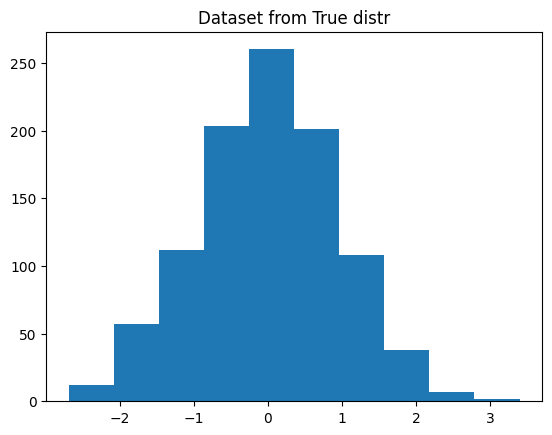

In [15]:
# generate some data
X_true = tfp.distributions.Normal(loc=mu_true, scale=1/tf.sqrt(tau_true))
dataset = X_true.sample(n_samples).numpy()

plt.hist(dataset)
plt.title('Dataset from True distr')

In [16]:
# Surrogate/ variational distribution: q(z)

def variational_posterior_params(dataset, alpha_0, beta_0, mu_0, tau_0, max_iter=100):

    N = len(dataset)
    mu_mle = np.mean(dataset)
    variance_mle = np.mean((dataset-mu_mle)**2)
    mu_s = (tau_0 * mu_0 + N*mu_mle) / (tau_0 + N)
    alpha_s = alpha_0 + (N + 1.0)/2.0
    beta_s = beta_0 # or random guess
    for i in range(max_iter):
        tau_s = (tau_0 + N) * alpha_s / beta_s
        beta_s = beta_0 + (tau_0+N)/tau_s/2 + tau_0 * N * (mu_0 - mu_mle)**2 / (2*(tau_0 + N)) + 1/2 * N * variance_mle
        
    return alpha_s, beta_s, mu_s, tau_s

alpha_s, beta_s, mu_s, tau_s = variational_posterior_params(dataset, alpha_0, beta_0, mu_0, tau_0, max_iter)

print('alpha_s %.3f, beta_s %.3f, mu_s %.3f, tau_s %.3f' %(alpha_s, beta_s, mu_s, tau_s))

alpha_s 501.500, beta_s 463.089, mu_s 0.003, tau_s 1086.195


In [17]:
# In this case we know the true posterior
def true_posterior_parameters(dataset, alpha_0, beta_0, mu_0, tau_0):
    N = len(dataset)

    mu_mle = np.mean(dataset)
    variance_mle = np.mean((dataset-mu_mle)**2)

    alpha_N = alpha_0 + N/2.0
    beta_N = beta_0 + 1/2 * tau_0 + N*(mu_0 - mu_mle)**2/(tau_0+N) + 1/2*N*variance_mle

    tau_N = tau_0 + N
    mu_N = (tau_0 * mu_0 + N*mu_mle)/(tau_0 + N)

    return alpha_N, beta_N, mu_N, tau_N

alpha_N, beta_N, mu_N, tau_N = true_posterior_parameters(dataset, alpha_0, beta_0, mu_0, tau_0)

print('alpha_N %.3f, beta_N %.3f, mu_N %.3f, tau_s %.3f' %(alpha_N, beta_N, mu_s, tau_N))

alpha_N 501.000, beta_N 462.127, mu_N 0.003, tau_s 1003.000


In [18]:
# MAP ESTIMATES

mu_s_MAP = mu_s
tau_s_MAP = (alpha_s - 1)/beta_s
print('variational MAP estimate: mu_s_MAP: %.4f, tau_s_MAP: %.4f'%(mu_s_MAP, tau_s_MAP))

mu_N_MAP = mu_N
tau_N_MAP = (alpha_N- 1/2)/beta_N
print('true posterior MAP estimate: mu_N_MAP: %.4f, tau_N_MAP: %.4f'%(mu_N_MAP, tau_N_MAP))


variational MAP estimate: mu_s_MAP: 0.0029, tau_s_MAP: 1.0808
true posterior MAP estimate: mu_N_MAP: 0.0029, tau_N_MAP: 1.0830


In [19]:
# craete generators using TF Probability

def gauss_gamma(alpha, beta, mu, tau):

    tau_dist = yield tfp.distributions.JointDistributionCoroutine.Root(
        tfp.distributions.Gamma(alpha, beta, name='tau')
    )

    mu_dist = yield tfp.distributions.Normal(loc=mu, scale=1/tf.sqrt(tau_dist * tau), name = 'mu')

def gauss_times_gamma(alpha, beta, mu, tau):

    tau_dist = yield tfp.distributions.JointDistributionCoroutine.Root(
        tfp.distributions.Gamma(alpha, beta, name='tau')
    )

    mu_dist = yield tfp.distributions.JointDistributionCoroutine.Root(
        tfp.distributions.Normal(loc=mu, scale = 1.0/tf.sqrt(tau), name='mu')
    )



In [20]:
# These are the generators

# -- for variational/surrogate

#convert to tensors
alpha_s, beta_s, mu_s, tau_s = tf.convert_to_tensor((alpha_s, beta_s, mu_s, tau_s))

variational_posterior = tfp.distributions.JointDistributionCoroutineAutoBatched(
    lambda: gauss_times_gamma(alpha_s, beta_s, mu_s, tau_s)
)

# -- for true posterior
alpha_N, beta_N, mu_N, tau_N = tf.convert_to_tensor((alpha_N, beta_N, mu_N, tau_N))

true_posterior = tfp.distributions.JointDistributionCoroutineAutoBatched(
    lambda: gauss_gamma(alpha_N, beta_N, mu_N, tau_N)
)


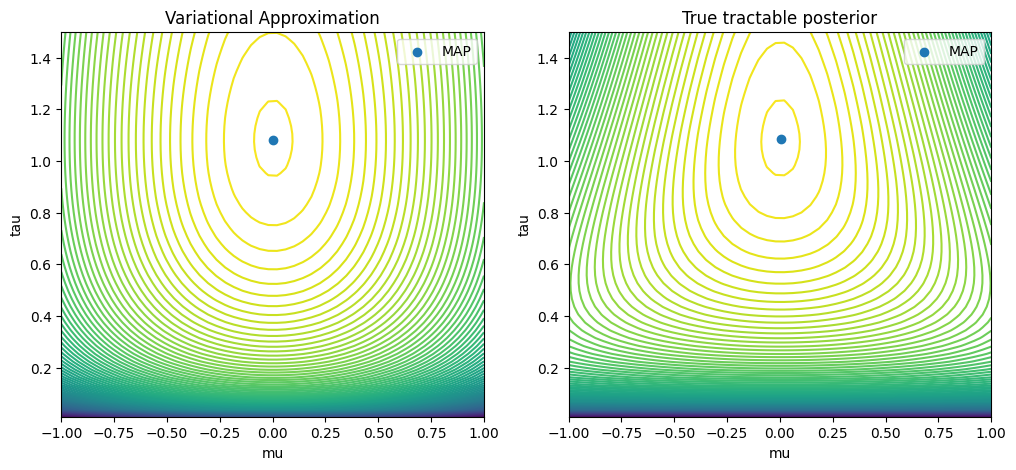

In [21]:
mu_range = tf.linspace(-1, 1, 50)
tau_range = tf.linspace(0.01, 1.5, 50)
mu_range = tf.cast(mu_range, 'float32')
tau_range = tf.cast(tau_range, 'float32')
mu_mesh, tau_mesh = tf.meshgrid(mu_range, tau_range)

points_2d = (tau_mesh, mu_mesh)

log_prob_variational_posterior = variational_posterior.log_prob(points_2d)

log_prob_true_posterior = true_posterior.log_prob(points_2d)


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))

ax1.contour(mu_mesh, tau_mesh, log_prob_variational_posterior, levels=100)
ax1.set_xlabel('mu')
ax1.set_ylabel('tau')
ax1.set_title('Variational Approximation')
ax1.scatter([mu_s_MAP],[tau_s_MAP], label='MAP')
ax1.legend()

ax2.contour(mu_mesh, tau_mesh, log_prob_true_posterior, levels=100)
ax2.set_xlabel('mu')
ax2.set_ylabel('tau')
ax2.set_title('True tractable posterior')
ax2.scatter([mu_N_MAP],[tau_N_MAP], label='MAP')
ax2.legend()

### Note
Observe the assumptions made by the variational approximation of independence of mu and tau. We dont get the typical triangular shape that is apparent in the true posterior. I.e mu and tau are in fact dependent, but we dont capture this in the mean field approximation. However, this does not matter as we were able to recover MAP estimates that are as close to the True model as the true posterior

Book: Bayesian Data Analysis

Redo with repara trick and stochastic optimization (Some paper)

U cant take gradient of parametrized 



# Stochastic Approach


-

In [22]:
log_prob_variational_posterior

<tf.Tensor: shape=(50, 50), dtype=float32, numpy=
array([[-2389.417  , -2345.8606 , -2304.114  , ..., -2298.42   ,
        -2339.9136 , -2383.2168 ],
       [-1704.577  , -1661.0209 , -1619.2742 , ..., -1613.5801 ,
        -1655.0736 , -1698.377  ],
       [-1437.8492 , -1394.2931 , -1352.5464 , ..., -1346.8523 ,
        -1388.3458 , -1431.6492 ],
       ...,
       [ -564.14795,  -520.5918 ,  -478.8451 , ...,  -473.15097,
         -514.64453,  -557.9478 ],
       [ -567.7649 ,  -524.2087 ,  -482.462  , ...,  -476.76788,
         -518.2615 ,  -561.5647 ],
       [ -571.59607,  -528.0399 ,  -486.2932 , ...,  -480.5991 ,
         -522.09265,  -565.39594]], dtype=float32)>

In [23]:
mu_mesh

<tf.Tensor: shape=(50, 50), dtype=float32, numpy=
array([[-1.       , -0.9591837, -0.9183673, ...,  0.9183673,  0.9591837,
         1.       ],
       [-1.       , -0.9591837, -0.9183673, ...,  0.9183673,  0.9591837,
         1.       ],
       [-1.       , -0.9591837, -0.9183673, ...,  0.9183673,  0.9591837,
         1.       ],
       ...,
       [-1.       , -0.9591837, -0.9183673, ...,  0.9183673,  0.9591837,
         1.       ],
       [-1.       , -0.9591837, -0.9183673, ...,  0.9183673,  0.9591837,
         1.       ],
       [-1.       , -0.9591837, -0.9183673, ...,  0.9183673,  0.9591837,
         1.       ]], dtype=float32)>

In [24]:
mu_range

<tf.Tensor: shape=(50,), dtype=float32, numpy=
array([-1.        , -0.9591837 , -0.9183673 , -0.877551  , -0.8367347 ,
       -0.79591835, -0.75510204, -0.71428573, -0.67346936, -0.63265306,
       -0.59183675, -0.5510204 , -0.5102041 , -0.46938777, -0.42857143,
       -0.3877551 , -0.3469388 , -0.30612245, -0.26530612, -0.2244898 ,
       -0.18367347, -0.14285715, -0.10204082, -0.06122449, -0.02040816,
        0.02040816,  0.06122449,  0.10204082,  0.14285715,  0.18367347,
        0.2244898 ,  0.26530612,  0.30612245,  0.3469388 ,  0.3877551 ,
        0.42857143,  0.46938777,  0.5102041 ,  0.5510204 ,  0.59183675,
        0.63265306,  0.67346936,  0.71428573,  0.75510204,  0.79591835,
        0.8367347 ,  0.877551  ,  0.9183673 ,  0.9591837 ,  1.        ],
      dtype=float32)>